# Elwah River Offset Arial Photo Matching

## Introduction

The purpose of this project is to prepare RGB and IR images taken of the Elwah river in 2012 for more advanced CV processing like cold water refuge mapping. The dataset is made up of photos taken by an IR camera and an RGB camera. As such, the RGB images and IR images do not align. There is an additional quirk adding complexity: the RGB images overlap, as do the IR images.

The goal of this project is to develop a process for matching images taken from slightly different camera angles. We will be accomplishing that in this case by stitching together RGB images via feature detection, like a panorama. Then, these stitched images will be transformed and sliced to match their corresponding IR, which will be identified via special feature detection. The final product should be a dataset of unmodified IR images and their corresponding reconstructed RGB matches.

## Problem Statement

In order for more advanced processing such as classification tasks to take place, there is a need to know for any given pixel in any given image both the RGB and IR data at that point. Unfortunately, the IR images are not only misaligned with the RGB images, they are also at a different scale (and perhaps focal length?). 

See figure 1.A on alignment below. In order to (roughly) match the IR image to the RGB image, the IR image had to be shrunken in order to map to the RGB data, despite the fact that the RBG and IR images seemingly have the same size of `640x480`.

<video width="320" autoplay loop muted>
  <source src="../img/alignment2.mp4" type="video/mp4">
  Figure 1.A
</video>

## Getting Started

In [19]:
import numpy as np
import os.path
import scipy.io
import cv2
from PIL import Image as im
import matplotlib.pyplot as plt

In [20]:
# We only use this running locally, since this data file is too big for Github.
# airborne_data_path = "../data/AirborneData.mat"
# This allows the code to be runnable on Binder or Colab
airborne_data_path = "../data/AirborneDataMini.mat"

# These files are smaller so we don't have to worry about them.
surfacetemp_data_path = "../data/SurfaceIRtemp.dat"
meta_data_path = "../data/InsituData.dat"

assert os.path.exists(airborne_data_path)
assert os.path.exists(surfacetemp_data_path)
assert os.path.exists(meta_data_path)

Loading the massive `mat` file takes a while so we place it in its own code cell.

In [21]:
airborne_data = scipy.io.loadmat(airborne_data_path)

Let's take a look at the keys.

In [22]:
airborne_keys = list(airborne_data.keys())
print(airborne_keys)

['__header__', '__version__', '__globals__', 'imageRGB', 'imageIR']


Looks like we have our images under 'imageRGB' and 'imageIR'.
Examining the format will help us figure out how to use the data.

In [23]:
raw_images = airborne_data[airborne_keys[3]]
print(type(raw_images))
print(raw_images.shape)

<class 'numpy.ndarray'>
(640, 480, 25, 3)


For some reason, the format the images are stored in seems to require us to index by the 3rd dimension.
The images are each 640x480 and 3 channel (RGB), and there are 406 in total.

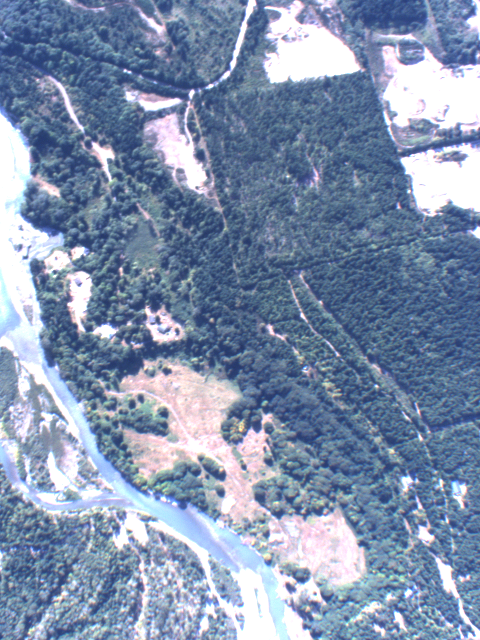

In [24]:
rgb_images = []
for x in range(25):
  image_data = im.fromarray(raw_images[:,:,x])
  rgb_images.append(image_data)
  image_data.save(f"../out/airborne_{x+1}.png")

display(rgb_images[10])

In [25]:
raw_ir_images = airborne_data[airborne_keys[4]]
print(type(raw_ir_images))
print(raw_ir_images.shape)

<class 'numpy.ndarray'>
(480, 640, 25)


Hmm... for some reason these images are sideways compared to the RGB ones. Also, pillow has trouble with this grayscale format for some reason so we are going save images with matplotlib.

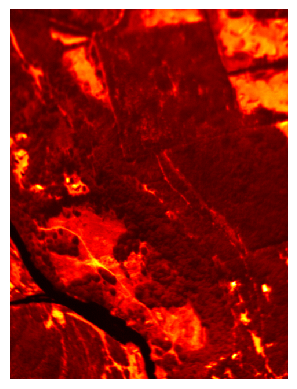

In [26]:
ir_images = []
for x in range(25):
  ir_image = np.rot90(raw_ir_images[:,:,x], -1, (0, 1))
  ir_images.append(ir_image)
  plt.imsave(f"../out/airborne_ir_{x+1}.png", ir_image, format="png", cmap="hot")

plt.imshow(ir_images[10], interpolation="none", cmap="hot")
plt.axis('off')
plt.show() # saved images won't look quite like this, as they won't have the white padding

## Stitching Test

Let's do a quick test to figure out how we will stitch and align our RGB images before we perform the operation on the entire dataset. Since the misalignment factor is constant throughout the dataset (the IR and RGB cameras were on the same plane, just at different angles) the way the first RGB and IR images misalign will be identical to the way the hundreth do.

In [27]:
test_paths = ["../out/airborne_1.png", "../out/airborne_2.png"]
test_images = []

for path in test_paths:
	image = cv2.imread(path)
	test_images.append(image)

In [28]:
stitcher = cv2.Stitcher_create()
(status, stitched) = stitcher.stitch(test_images)

In [29]:
# status 0 indicates success
if status == 0:
	cv2.imwrite("../out/stitch_test.png", stitched)
else:
	print("(err) image stitching failed ({})".format(status))

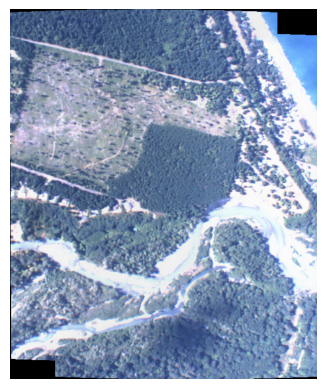

In [30]:
plt.imshow(stitched[:,:,::-1]) # the slice notation is inverting
plt.axis("off")
plt.show()

Eyeballing it, here we can see that the 2nd infrared image aligns with the first and second RGB images. This means we can match every IR image fully with the exception of the first IR image.

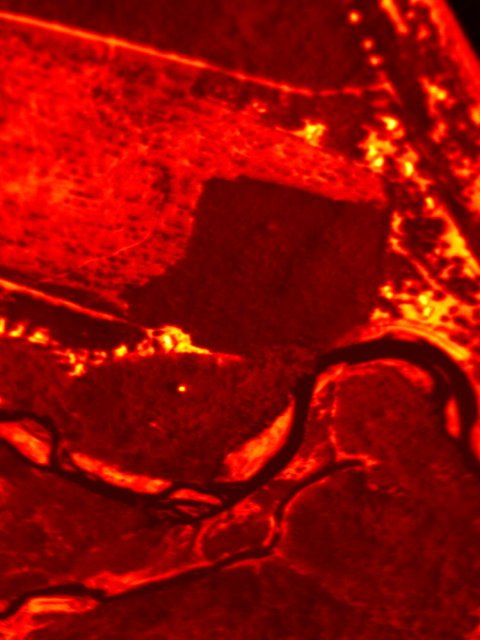

In [31]:
im.open("../out/airborne_ir_2.png")

Now, we have to figure out what kind of descriptors we are going to use to figure out the alignment of the IR and RGB images. For a dataset where it is not as immediately obvious which images overlap with which and eyeballing it isn't going to cut it, the application of keypoints and descriptors could be used to match the images, but we will only be using them to figure out how to crop the stitched RGB images.

In [32]:
imrgb = cv2.imread('../out/airborne_1.png')[:,:,::-1]
imir = cv2.imread('../out/airborne_ir_2.png', cv2.IMREAD_GRAYSCALE)

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(imrgb, None)
kp2, des2 = orb.detectAndCompute(imir, None)

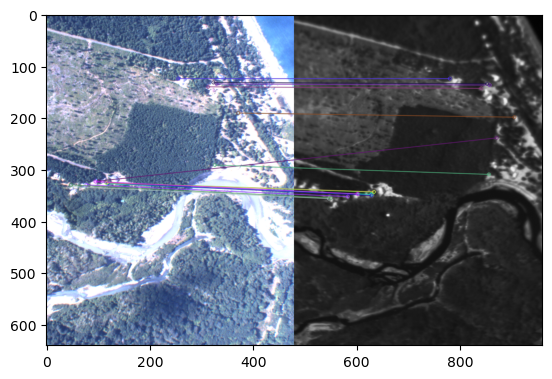

In [33]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first/best 15 matches.
vis = cv2.drawMatches(imrgb, kp1, imir, kp2, matches[:15], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(vis)
plt.show()

Looks like ORB descriptors don't do a half bad job of matching the images!

In [34]:
# imrgb = cv2.imread('../out/airborne_1.png')
imrgb = cv2.imread('../out/stitch_test.png')[:,:,::-1] # opencv reads BGR so we use this notation to reverse the order
imir = cv2.imread('../out/airborne_ir_2.png', cv2.IMREAD_GRAYSCALE)

# Initiate BRISK detector
brisk = cv2.BRISK_create()

# find the keypoints and descriptors with BRISK
kp1, des1 = brisk.detectAndCompute(imrgb, None)
kp2, des2 = brisk.detectAndCompute(imir, None)

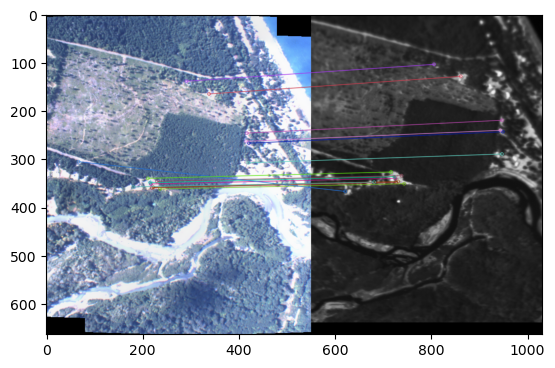

In [35]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1, des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first/best 15 matches.
vis = cv2.drawMatches(imrgb, kp1, imir, kp2, matches[:15], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(vis)
plt.show()

However, BRISK descriptors seem to do a slightly better job of matching. This makes sense as "BRISK slightly outperforms BRIEF in viewpoint changes, but performs about the same as ORB in overall."

The way `BFMatcher` works is that it returns to us a list of `cv2.DMatch` objects. Each of these objects has a `queryIdx` and `trainIdx` attribute. These correspond to the index in kp1 and kp2 which the match represents, respectively. Therefore we can obtain the image coordinates of the best matches with the following code.

In [36]:
rgb_coords = []
ir_coords = []

for match in matches:
  rgb_kp_index = match.queryIdx
  ir_kp_index = match.trainIdx

  rgb_coords.append(kp1[rgb_kp_index].pt)
  ir_coords.append(kp2[ir_kp_index].pt)

Recall our images are 640x480, lets take a look what our points look like by ploting the coordinates for the first 15 matches. It should match the matches we have up above in the previous step.

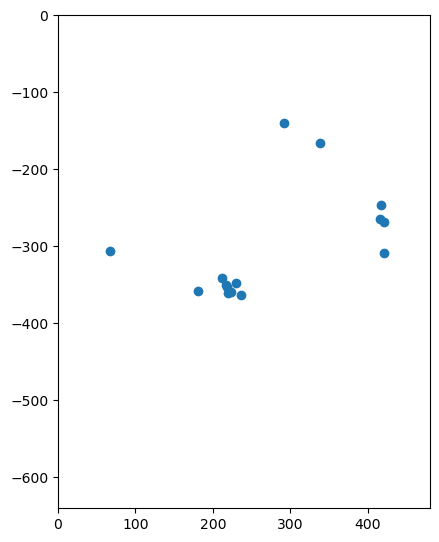

In [37]:
x_val = [pt[0] for pt in rgb_coords[:15]]
y_val = [-pt[1] for pt in rgb_coords[:15]] # negative because img coords start 0,0 at the top left with +y going down

plt.figure(figsize=(4.8, 6.4))
plt.scatter(x_val, y_val)
plt.xlim([0, 480])
plt.ylim([-640, 0])
plt.show()

Great, that seems to match. We will use the relative positions of these coordinates in the RGB image and their corresponding matched coordinates in the IR image to figure out how to map the bounds of the IR image onto the RGB image. Doing this on a per image basis ensures that varying levels of misalignment throughout the dataset don't matter, since we realign each image based on its own matches.